In [8]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import sys
import argparse
from tqdm import tqdm
import pandas as pd
import gc
#sys.path.insert(0, '../lenstronomy/lenstronomy/')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF


In [9]:
# simulation 2019-7-29 12:26 CT by Joshua Yao-Yu Lin

z_lens = 0.6
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
#psf_filename = os.path.join(module_path, 'git_work_zone/lenstronomy_extensions/Data/PSF_TinyTim/psf_example.fits')
psf_filename_list = []
psf_filename_101 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed101/drizzled_image/psf.fits')
psf_filename_102 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed102/drizzled_image/psf.fits')
psf_filename_103 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed103/drizzled_image/psf.fits')
psf_filename_104 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed104/drizzled_image/psf.fits')
psf_filename_105 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed105/drizzled_image/psf.fits')
#psf_filename_106 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed106/drizzled_image/psf.fits')
psf_filename_107 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed107/drizzled_image/psf.fits')
psf_filename_108 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed108/drizzled_image/psf.fits')
psf_filename_109 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code1/f160w-seed109/drizzled_image/psf.fits')
psf_filename_110 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed110/drizzled_image/psf.fits')
psf_filename_111 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed111/drizzled_image/psf.fits')
#psf_filename_112 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed112/drizzled_image/psf.fits')
psf_filename_113 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed113/drizzled_image/psf.fits')
psf_filename_114 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed114/drizzled_image/psf.fits')
psf_filename_115 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed115/drizzled_image/psf.fits')
psf_filename_116 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed116/drizzled_image/psf.fits')
psf_filename_117 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed117/drizzled_image/psf.fits')
psf_filename_118 = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed118/drizzled_image/psf.fits')
psf_filename_list.append(psf_filename_101)
psf_filename_list.append(psf_filename_102)
psf_filename_list.append(psf_filename_103)
psf_filename_list.append(psf_filename_104)
psf_filename_list.append(psf_filename_105)
#psf_filename_list.append(psf_filename_106)
psf_filename_list.append(psf_filename_107)
psf_filename_list.append(psf_filename_108)
psf_filename_list.append(psf_filename_109)
psf_filename_list.append(psf_filename_110)
psf_filename_list.append(psf_filename_111)
#psf_filename_list.append(psf_filename_112)
psf_filename_list.append(psf_filename_113)
psf_filename_list.append(psf_filename_114)
psf_filename_list.append(psf_filename_115)
psf_filename_list.append(psf_filename_116)
psf_filename_list.append(psf_filename_117)
psf_filename_list.append(psf_filename_118)




#kernel = pyfits.getdata(psf_filename_list[0])

# plt.matshow(np.log10(kernel))
# plt.show()

# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.6
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
#psf_filename = os.path.join(module_path, 'git_work_zone/lenstronomy_extensions/Data/PSF_TinyTim/psf_example.fits')
psf_filename = os.path.join('/media/joshua/HDD_fun2/time_delay_challenge/rung1/code2/f160w-seed110/drizzled_image/psf.fits')
kernel = pyfits.getdata(psf_filename)

# plt.matshow(np.log10(kernel))
# plt.show()

# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
psf_class = PSF(**kwargs_psf)






simulation started


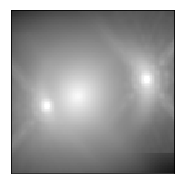

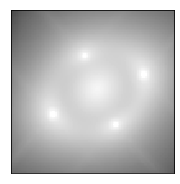

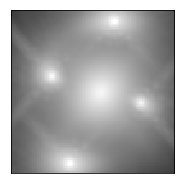

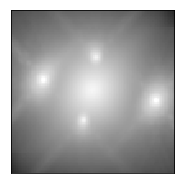

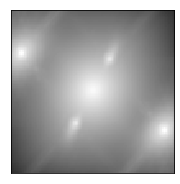

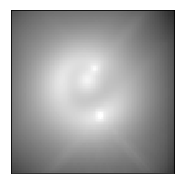

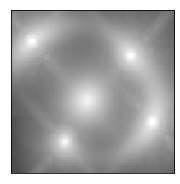

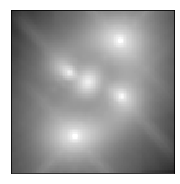

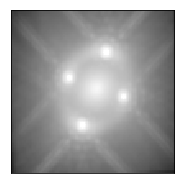

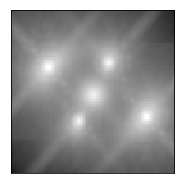

In [10]:
if __name__ == "__main__":
    print("simulation started")
    show_img = True
    IsTrain = False
    num_samples = 10
    root_folder = "/media/joshua/HDD_fun2/time_delay_challenge/Demo_sims/"
    if not os.path.exists(root_folder):
        os.mkdir(root_folder)

    if IsTrain:
        np.random.seed(12345)
        file_path = root_folder+"train/"
    else:
        np.random.seed(54321)
        file_path = root_folder+"test/"

    if not os.path.exists(file_path):
        os.mkdir(file_path)



    for i in range(num_samples):
        # lensing quantities
        psf_seed = i % len(psf_filename_list)

        kernel = pyfits.getdata(psf_filename_list[psf_seed])


        # generate the coordinate grid and image properties
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
        data_class = ImageData(**kwargs_data)
        # generate the psf variables
        kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
        kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
        #kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
        psf_class = PSF(**kwargs_psf)
        # lensing quantities

        ### mean of the lens parameters
        gamma_ext_mu, theta_E_mu, gamma_mu, lens_center_mu, lens_e_mu = 0.015, 1.25, 2.0, 0.0, 0.0

        gamma_ext_sigma, theta_E_sigma, gamma_sigma, lens_center_sigma, lens_e_sigma= 0.005, 0.4, 0.05, 0.2, 0.2

        gamma_ext = np.maximum(np.random.normal(gamma_ext_mu, gamma_ext_sigma), 0)
        psi_ext = np.random.uniform(0.0, 2* np.pi)
        theta_E = np.maximum(np.random.normal(loc=theta_E_mu, scale=theta_E_sigma), 0.1)
        gamma = np.maximum(np.random.normal(gamma_mu, gamma_sigma), 1.85)
        lens_center_x = np.random.normal(lens_center_mu, lens_center_sigma)
        lens_center_y = np.random.normal(lens_center_mu, lens_center_sigma)
        lens_e1 = np.minimum(np.random.normal(lens_e_mu, lens_e_sigma), 0.9)
        lens_e2 = np.minimum(np.random.normal(lens_e_mu, lens_e_sigma), 0.9)

        kwargs_shear = {'gamma_ext': gamma_ext, 'psi_ext': psi_ext}  # shear values to the source plane
        kwargs_spemd = {'theta_E': theta_E, 'gamma': gamma, 'center_x': lens_center_x, 'center_y': lens_center_y, 'e1': lens_e1, 'e2': lens_e2}  # parameters of the deflector lens model

        # the lens model is a supperposition of an elliptical lens model with external shear
        lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
        kwargs_lens = [kwargs_spemd, kwargs_shear]
        lens_model_class = LensModel(lens_model_list=lens_model_list)



        # choice of source type
        source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'
        source_position_mu = 0.0
        source_position_sigma = 0.1
        #sigma_source_position = 0.1
        source_x = np.random.normal(source_position_mu, source_position_sigma)
        source_y = np.random.normal(source_position_mu, source_position_sigma)


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        sersic_source_e1, sersic_source_e2 = param_util.phi_q2_ellipticity(phi_G, q)
        source_R_sersic_mu, source_R_sersic_sigma = 0.2, 0.1
        source_n_sersic_mu, source_n_sersic_sigma = 1.0, 0.1
        source_R_sersic = np.random.normal(source_R_sersic_mu, source_R_sersic_sigma)
        source_n_sersic = np.random.normal(source_n_sersic_mu, source_n_sersic_sigma)



        kwargs_sersic_source = {'amp': 4000, 'R_sersic': source_R_sersic, 'n_sersic': source_n_sersic, 'e1': sersic_source_e1, 'e2': sersic_source_e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)

        # lens light model
        phi_G, q = 0.9, 0.9
        lens_light_e1, lens_light_e2 = param_util.phi_q2_ellipticity(phi_G, q)
        lens_light_R_sersic_mu, lens_light_R_sersic_sigma = 0.3, 0.1
        lens_light_n_sersic_mu, lens_light_n_sersic_sigma = 1.0, 0.1
        lens_light_R_sersic = np.random.normal(lens_light_R_sersic_mu, lens_light_R_sersic_sigma)
        lens_light_n_sersic = np.random.normal(lens_light_n_sersic_mu, lens_light_n_sersic_sigma)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': lens_light_R_sersic, 'n_sersic': lens_light_n_sersic , 'e1': lens_light_e1, 'e2': lens_light_e2, 'center_x': lens_center_x, 'center_y': lens_center_y}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

        lensEquationSolver = LensEquationSolver(lens_model_class)
        x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                              min_distance=deltaPix, search_window=numPix * deltaPix)
        mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
        kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                                   'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
        point_source_list = ['LENSED_POSITION']
        point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

        kwargs_numerics = {'supersampling_factor': 1}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
        #poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        #bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
        image_sim = image_sim# + bkg + poisson

        data_class.update_data(image_sim)
        kwargs_data['image_data'] = image_sim


        kwargs_model = {'lens_model_list': lens_model_list,
                         'lens_light_model_list': lens_light_model_list,
                         'source_light_model_list': source_model_list,
                        'point_source_model_list': point_source_list
                         }



        ##### saving files
        np.save(file_path + "lens" + "_" + "%07d" % (i+1) + ".npy", image_sim)
        ##### saveing parameters
        lens_dict = kwargs_lens[0]
        shear_dict = kwargs_shear
        df_lens  = pd.DataFrame([lens_dict], columns=lens_dict.keys())
        df_lens['gamma_ext'] = gamma_ext
        df_lens['psi_ext'] = psi_ext
        #df_shear = pd.DataFrame([shear_dict], columns=shear_dict.keys())
        df_lens['name'] = "lens" + "_" + "%07d" % (i+1)
        df_lens['source_R_sersic'] = source_R_sersic
        df_lens['source_n_sersic'] = source_n_sersic
        df_lens['sersic_source_e1'] = sersic_source_e1
        df_lens['sersic_source_e2'] = sersic_source_e2
        df_lens['source_x'] = source_x
        df_lens['source_y'] = source_y
        df_lens['lens_light_e1'] = lens_light_e1
        df_lens['lens_light_e2'] = lens_light_e2
        df_lens['lens_light_R_sersic'] = lens_light_R_sersic
        df_lens['lens_light_n_sersic'] = lens_light_n_sersic

        # lens_light_R_sersic = np.random.normal(lens_light_R_sersic_mu, lens_light_R_sersic_sigma)
        # lens_light_n_sersic


        if i > 0:
            df_lens_podcast = pd.concat([df_lens_podcast, df_lens], axis =0).reset_index(drop=True)
        else:
            df_lens_podcast = df_lens

        if show_img == True:
            cmap_string = 'gray'
            cmap = plt.get_cmap(cmap_string)
            cmap.set_bad(color='k', alpha=1.)
            cmap.set_under('k')

            v_min = -4
            v_max = 2

            f, axes = plt.subplots(1, 1, figsize=(3, 3), sharex=False, sharey=False)
            ax = axes
            im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.autoscale(False)
            plt.show()
    df_lens_podcast = df_lens_podcast[['name', 'theta_E', 'gamma', 'center_x', 'center_y', 'e1', 'e2', 'gamma_ext', 'psi_ext', 'source_x', 'source_y', 'source_n_sersic', 'source_R_sersic', 'sersic_source_e1', 'sersic_source_e2', 'lens_light_e1', 'lens_light_e2', 'lens_light_n_sersic', 'lens_light_R_sersic']]
    df_lens_podcast.to_csv(file_path + "lens_info.csv")
    

In [12]:
print(df_lens_podcast.head())

           name   theta_E     gamma  center_x  center_y        e1        e2  \
0  lens_0000001  1.547836  2.070155 -0.458091 -0.159783 -0.033372 -0.012195   
1  lens_0000002  1.337997  2.049649  0.144186  0.067752 -0.096564 -0.102037   
2  lens_0000003  1.795608  1.998401  0.244454 -0.040968  0.203246 -0.124329   
3  lens_0000004  1.349875  2.049805 -0.010321  0.038776 -0.264396  0.114627   
4  lens_0000005  1.722490  2.051815  0.006020  0.027776 -0.227671  0.338729   

   gamma_ext   psi_ext  source_x  source_y  source_n_sersic  source_R_sersic  \
0   0.016120  4.975050  0.153187  0.005465         1.077027         0.136077   
1   0.010828  0.653015  0.133073 -0.016521         1.130237         0.342971   
2   0.020824  0.293486  0.070062 -0.066311         1.020871         0.186962   
3   0.021876  0.213632  0.209668  0.015961         0.935799         0.199708   
4   0.015733  5.614330  0.003036 -0.009646         1.056121         0.221825   

   sersic_source_e1  sersic_source_e2  lens_